In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

import snntorch as snn


from tqdm import tqdm

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Train plain SNN

In [3]:
class SNN (nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta):
        super().__init__()
        
        self.fc1 = nn.Linear(num_inputs,num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x) :
        # Initiamize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [4]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 5

# Temporal Dynamics
num_steps = 25
beta = 0.95

## Setup datasets

In [5]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST 
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
batch_size=128

### Digits 0 to 4

In [7]:
# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader_1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_1 = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_1 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [8]:
task_1 = "task_1"

### Digits 5 to 9

In [9]:
# keep images of desired labels
class_names = [5, 6, 7, 8, 9]

# create a mask to filter indices for each label
train_mask_2 = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask_2 = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset_2 = Subset(mnist_train, torch.where(train_mask_2)[0])
test_dataset_2 = Subset(mnist_test, torch.where(test_mask_2)[0])

# split train into train & validation
train_size_2 = int(0.7 * len(train_dataset_2))
val_size_2 = len(train_dataset_2) - train_size_2
train_dataset_2, val_dataset_2 = random_split(train_dataset_2, [train_size_2, val_size_2])

train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=False, drop_last=True)

In [10]:
task_2 = "task_2"

## Train plain SNN

In [11]:
task = task_1
train_loader = train_loader_1
val_loader = val_loader_1

In [12]:
def get_batch_accuracy(model, data, targets):
    output, _ = model(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    return round(acc*100,2)

In [13]:
def compute_val (model, val_loader, val_loss_hist, val_acc_hist, comp_mode=False, print_shit=False) :
    model.eval()
    val_data, val_targets = next(iter(val_loader))
    val_data = val_data.to(device)
    if task == "task_2" and not(comp_mode) :
        val_targets -= 5
    val_targets = val_targets.to(device)

    val_spk, val_mem = model(val_data.view(batch_size, -1))

    # LOSS
    val_loss = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
        val_loss += loss(val_mem[step], val_targets)
    val_loss_hist.append(val_loss.item())
    
    # ACCURACY
    if print_shit :
        print(f"Epoch {epoch}")
        # print(f"Train Set Loss: {train_loss_hist[epoch]:.2f}")
        print(f"Val Set Loss: {val_loss_hist[epoch]:.2f}")
        print("\n")
    val_acc_hist.append(get_batch_accuracy(model, val_data, val_targets))
    
    
    return val_loss_hist, val_acc_hist

In [14]:
def train (model, task, optimizer, train_loader, val_loader, num_epochs=10, device=device, comp_val_loader=None) :
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    if comp_val_loader :
        comp_val_loss_hist, comp_val_acc_hist = [], []

    # Outer training loop
    for epoch in tqdm(range(num_epochs)):
        train_batch = iter(train_loader)
        loss_epoch = 0
        batch_index = 0

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            if task == "task_2" :
                targets -= 5
            targets = targets.to(device)

            # forward pass
            model.train()
            spk_rec, mem_rec = model(data.view(batch_size, -1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            loss_epoch += loss_val.item()
            batch_index += 1

            if batch_index%50 == 0:
                print(f'{batch_index} batches used in epoch {epoch}')

        # Store loss and acc histories for future plotting
        train_loss_hist.append(loss_epoch/len(train_loader))
        train_acc_hist.append(get_batch_accuracy(model, data, targets))

        
        # Test set
        with torch.no_grad():
            if epoch % 1 == 0:
                val_loss_hist, val_acc_hist = compute_val (model, 
                                                           val_loader, 
                                                           val_loss_hist, 
                                                           val_acc_hist, 
                                                           print_shit=False)
                if comp_val_loader:
                    comp_val_loss_hist, comp_val_acc_hist = compute_val (model, 
                                                                         comp_val_loader, 
                                                                         comp_val_loss_hist, 
                                                                         comp_val_acc_hist,
                                                                         comp_mode=True,
                                                                         print_shit=False)
                    
    output = [train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist]
    if comp_val_loader :
        output += [comp_val_loss_hist, comp_val_acc_hist]
    return output

In [15]:
snn_model = SNN(num_inputs, num_hidden, num_outputs, beta).to(device)

In [16]:
dtype = torch.float
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn_model.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [17]:
output = train(snn_model, task, optimizer, train_loader, val_loader, num_epochs=5, device=device)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = output

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

50 batches used in epoch 0
100 batches used in epoch 0
150 batches used in epoch 0


 20%|████████████████▊                                                                   | 1/5 [00:25<01:41, 25.32s/it]

50 batches used in epoch 1
100 batches used in epoch 1
150 batches used in epoch 1


 40%|█████████████████████████████████▌                                                  | 2/5 [00:49<01:14, 24.93s/it]

50 batches used in epoch 2
100 batches used in epoch 2
150 batches used in epoch 2


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:13<00:49, 24.51s/it]

50 batches used in epoch 3
100 batches used in epoch 3
150 batches used in epoch 3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:38<00:24, 24.65s/it]

50 batches used in epoch 4
100 batches used in epoch 4
150 batches used in epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:03<00:00, 24.76s/it]


In [26]:
def plot_losses(train_loss_hist, val_loss_hist, comp_val_loss_hist=None):
    plt.plot(train_loss_hist,label="Optimized task : train",c="green")
    plt.plot(val_loss_hist,label="Optimized task : val",c="lime")
    
    if comp_val_loss_hist :
        plt.plot(comp_val_loss_hist,label="Side task : val",c="red")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

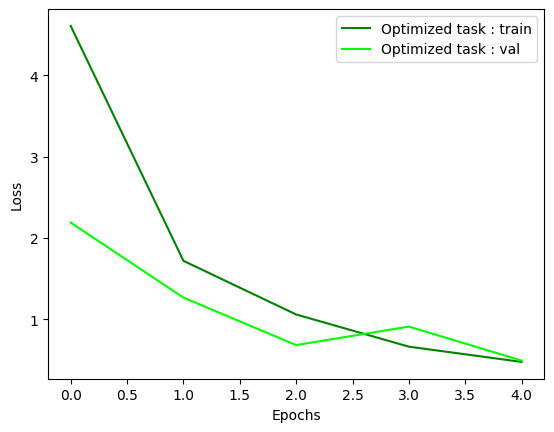

In [19]:
plot_losses(train_loss_hist, val_loss_hist)

In [27]:
def plot_accs(train_acc_hist, val_acc_hist, comp_val_acc_hist=None):
    plt.plot(train_acc_hist,label="Optimized task : train",c="green")
    plt.plot(val_acc_hist,label="Optimized task : val",c="lime")
    
    if comp_val_acc_hist :
        plt.plot(val_acc_hist,label="Side task : val",c="red")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

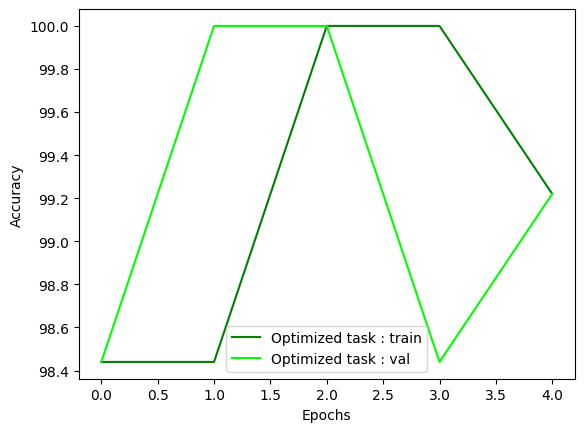

In [21]:
plot_accs(train_acc_hist, val_acc_hist)

## Test snn_model on both tasks

In [15]:
def test (model, loader, task) :
    batch_accs_list = []
    for batch in iter(loader) :
        data, targets = iter(batch)
        data, targets = data.to(device), targets.to(device)
        output, _ = model(data.view(batch_size, -1))
        _, idx = output.sum(dim=0).max(1)
        if task == "task_2" :
            targets -= 5
        batch_acc = np.mean((targets == idx).detach().cpu().numpy())
        batch_accs_list.append(batch_acc)

    return round(np.mean(batch_accs_list)*100,2)

In [23]:
print(f"snn_model achieve {test(snn_model, test_loader_1, task_1)}% accuracy on task 1")
print(f"snn_model achieve {test(snn_model, test_loader_2, task_2)}% accuracy on task 2")

snn_model achieve 98.87% accuracy on task 1
snn_model achieve 33.59% accuracy on task 2


## Save snn_model weights

## Define LoRA for SNN

In [64]:
def retrieve_model_weights(model) :
    cur_size_out = 0
    for child in model.named_children() :
        layer_name = child[0]
        if layer_name[:2] == "fc" :
            cur_size_out = child[1].out_features
        elif layer_name[:3] == "lif" :
            layer = getattr(model, layer_name)
            mem1 = layer.init_leaky()
            cur1 = torch.zeros((batch_size, cur_size_out))
            spk1, mem1 = layer(cur1, mem1)
    
    return model

In [65]:
class LoRA_SNN(nn.Module):
    def __init__(self, lora_rank, path, num_inputs, num_hidden, num_outputs, beta):
        super(LoRA_SNN, self).__init__()
        
        # Load the pretrained model
        model = SNN(num_inputs, num_hidden, num_outputs, beta)
        self.model = retrieve_model_weights(model)
        self.model.load_state_dict(torch.load(path))
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0)
        
        # Define LoRA hyperparameters
        self.lora_rank = lora_rank
        
        # Define LoRA weights matrices for each layer in pretrained model
        self.l1_lora_A = nn.Parameter(torch.Tensor(self.model.fc1.in_features, lora_rank))
        self.l1_lora_B = nn.Parameter(torch.Tensor(lora_rank, self.model.fc1.out_features))
        
        self.l2_lora_A = nn.Parameter(torch.Tensor(self.model.fc2.in_features, lora_rank))
        self.l2_lora_B = nn.Parameter(torch.Tensor(lora_rank, self.model.fc2.out_features))
        
        # Initialization for LoRA layers
        nn.init.kaiming_uniform_(self.l1_lora_A, a=np.sqrt(5))
        # nn.init.xavier_normal_(self.l1_lora_A)#, mean=0.0, std=1.0)
        nn.init.zeros_(self.l1_lora_B)
        
        nn.init.kaiming_uniform_(self.l2_lora_A, a=np.sqrt(5))
        # nn.init.xavier_normal_(self.l2_lora_A)#, mean=0.0, std=1.0)
        nn.init.zeros_(self.l2_lora_B)
        
        # Freeze non-LoRA weights
        self.model.fc1.weight.requires_grad = False
        self.model.fc1.bias.requires_grad = False
        self.model.fc2.weight.requires_grad = False
        self.model.fc2.bias.requires_grad = False
        
    def lora_linear(self, x, layer, lora_A, lora_B):
        h = torch.add(layer(x),1.8*torch.mm(torch.mm(x, lora_A), lora_B))
        return h
        
    def forward(self, x):
        # x = input.view(-1, 28*28)
        # Initiamize hidden states at t=0
        mem1 = self.model.lif1.init_leaky()
        mem2 = self.model.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        for step in range(num_steps):
            # Apply LoRA layer 1
            cur1 = self.lora_linear(x, self.model.fc1, self.l1_lora_A, self.l1_lora_B)
            cur1 = self.relu(cur1)
            cur1 = self.dropout(cur1)
            
            # Apply LIF layer 1 
            spk1, mem1 = self.model.lif1(cur1, mem1)
            
            # Apply LoRA layer 2
            cur2 = self.lora_linear(spk1, self.model.fc2, self.l2_lora_A, self.l2_lora_B)
            cur2 = self.relu(cur2)
            cur2 = self.dropout(cur2)
            
            # Apply LIF layer 2
            spk2, mem2 = self.model.lif2(cur2, mem2)
            
            # Record the time step
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [66]:
# LoRA_SNN's parameters have to be the same as SNN's ones
lora_rank = 64
path="SNN_LoRA/state_dict.pth"
num_inputs = 28*28
num_hidden = 1000
num_outputs = 5
beta = 0.95

lora_snn_model = LoRA_SNN(lora_rank, path, num_inputs, num_hidden, num_outputs, beta).to(device)

In [67]:
# Count the parameters in the linear layers (which does not include parameters within LIF layers)
def count_lora_parameters(model):
    lora_params = []
    for param_name, param in model.named_parameters():
        if not 'lora' in param_name:
            lora_params.append(param)
    num_lora_params = sum(torch.numel(param) for param in lora_params)
    return num_lora_params

lora_param_count = count_lora_parameters(lora_snn_model)
print("Number of none LoRA parameters of the linear layers (not trainable):", lora_param_count)

Number of none LoRA parameters of the linear layers (not trainable): 790005


In [68]:
# Count the parameters introduced by lora layers
def count_lora_parameters(model):
    lora_params = []
    for param_name, param in model.named_parameters():
        if 'lora' in param_name:
            lora_params.append(param)
    num_lora_params = sum(torch.numel(param) for param in lora_params)
    return num_lora_params

lora_param_count = count_lora_parameters(lora_snn_model)
print("Number of parameters introduced by LoRA (trainable):", lora_param_count)

Number of parameters introduced by LoRA (trainable): 178496


## Test the loaded model on both tasks

In [69]:
print(f"snn_model achieve {test(lora_snn_model, test_loader_1, task_1)}% accuracy on task 1")
print(f"snn_model achieve {test(lora_snn_model, test_loader_2, task_2)}% accuracy on task 2")

snn_model achieve 98.2% accuracy on task 1
snn_model achieve 33.74% accuracy on task 2


## Train LoRA

In [70]:
task = task_2
train_loader = train_loader_2
val_loader = val_loader_2
comp_val_loader = val_loader_1

In [96]:
dtype = torch.float
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [72]:
output = train(lora_snn_model, task, optimizer, train_loader, val_loader, num_epochs=1, device=device, comp_val_loader=comp_val_loader)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist, comp_val_loss_hist, comp_val_acc_hist = output

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

50 batches used in epoch 0
100 batches used in epoch 0
150 batches used in epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.29s/it]


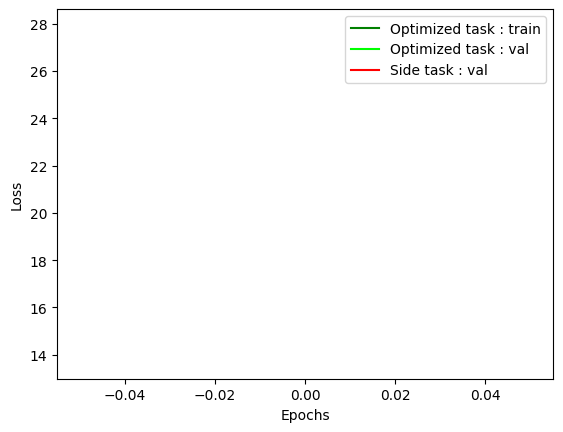

In [73]:
plot_losses(train_loss_hist, val_loss_hist, comp_val_loss_hist)

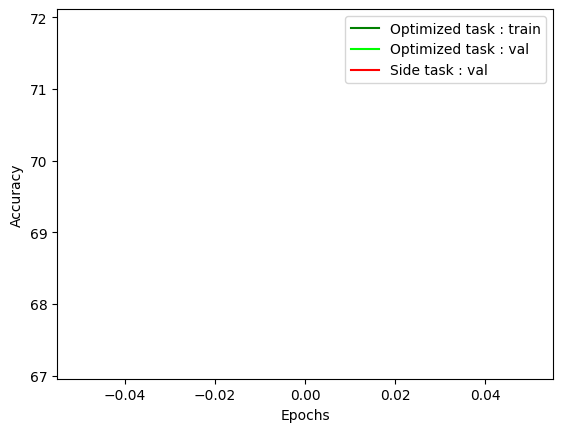

In [74]:
plot_accs(train_acc_hist, val_acc_hist, comp_val_acc_hist)

## Test the trained LoRA SNN on both tasks

In [75]:
print(f"lora_snn_model achieve {test(lora_snn_model, test_loader_1, task_1)}% accuracy on task 1")
print(f"lora_snn_model achieve {test(lora_snn_model, test_loader_2, task_2)}% accuracy on task 2")

lora_snn_model achieve 73.52% accuracy on task 1
lora_snn_model achieve 70.97% accuracy on task 2
